# Multi-Layer Perceptron 

- 多层感知机，即三层前馈神经网络。
- 由输入层，隐层和输出层组成


## Activate Functions


In [6]:
%matplotlib inline
import torch
import numpy as np
import matplotlib.pylab as plt
import sys
sys.path.append("..") 
import d2lzh_pytorch as d2l

def xyplot(x_vals, y_vals, name):
    d2l.set_figsize(figsize=(5, 2.5))
    d2l.plt.plot(x_vals.detach().numpy(), y_vals.detach().numpy())
    d2l.plt.xlabel('x')
    d2l.plt.ylabel(name + '(x)')


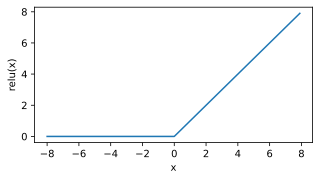

In [27]:
# the ReLU function
# plot relu

x = torch.arange(-8.0, 8.0, 0.1, requires_grad=True)
y = x.relu()
#y = x.sigmoid()
#y = x.tanh()
# 

xyplot(x,y,'relu')

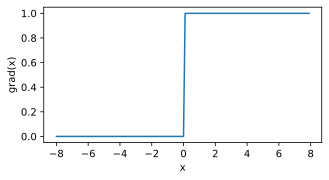

In [28]:
# plot x-grad with x

#x.grad.zero_()  # clear the gradient 
y.sum().backward()  # use .sum() to turn tesor to scala 
xyplot(x,x.grad,'grad')


## Using PyTorch

In [2]:
import torch
from torch import nn
from torch.nn import init
import numpy as np
import sys
import d2lzh_pytorch as d2dl


In [5]:
# Hyperparameters
num_inputs = 784
num_outputs = 10
num_hiddens = 256

batch_size = 256
learning_rate = 0.5

num_epochs = 5

# Load Data
train_iter, test_iter = d2dl.load_data_fashion_mnist(batch_size,root='/Users/yanzheyuan/coding/dataset_pytorch/')

# Define Model
net = nn.Sequential()
net.add_module('flatten',d2dl.FlattenLayer())
net.add_module('linear_1',nn.Linear(num_inputs,num_hiddens))
net.add_module('relu',nn.ReLU())
net.add_module('linear_2',nn.Linear(num_hiddens,num_outputs))

print(net)

loss_func = nn.CrossEntropyLoss()
optimizor = torch.optim.SGD(net.parameters(), learning_rate)


# Train Model
# initialize the parameters
for param in net.parameters():
    init.normal_(param, mean=0, std=0.01)
d2dl.train_ch3(net, train_iter, test_iter, loss_func, num_epochs, batch_size, None, None, optimizor)


Sequential(
  (flatten): FlattenLayer()
  (linear_1): Linear(in_features=784, out_features=256, bias=True)
  (relu): ReLU()
  (linear_2): Linear(in_features=256, out_features=10, bias=True)
)
epoch 1, loss 0.0031, train acc 0.707, test acc 0.739
epoch 2, loss 0.0019, train acc 0.819, test acc 0.827
epoch 3, loss 0.0016, train acc 0.844, test acc 0.806
epoch 4, loss 0.0015, train acc 0.854, test acc 0.817
epoch 5, loss 0.0014, train acc 0.865, test acc 0.851
